### Consumption

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

consumption = pd.read_excel('../../Data/Consumption/Consumption_matrix.xlsx', index_col = 0) * 0.01
consumption.index = pd.date_range(start = '2000-01-01', end='2023-11-01', freq='M').strftime('%Y-%m')
consumption.index = pd.to_datetime(consumption.index)

In [41]:
consumption

,moneraty_rate,cpi_rate,ccpi_without_arg_crd_oil,ccpi_without_food_energy,retail_consumption,vehicle_consumption,credit_card_consumption,hushld_loan,mortgage_loan,credit_loan,durb_goods_sales,quas_drub_goods_sales,non_durb_goods_sales
2000-01-01,0.032,0.019,0.011,0.007,0.512,0.301,NaN,0.1014,NaN,NaN,0.447,0.105,0.108
2000-02-01,0.014,0.018,0.011,0.008,0.519,0.330,NaN,0.1004,NaN,NaN,0.541,0.095,0.091
2000-03-01,0.023,0.021,0.015,0.013,0.516,0.294,NaN,0.1005,NaN,NaN,0.383,0.100,0.092
2000-04-01,0.018,0.014,0.016,0.015,0.527,0.262,NaN,0.0996,NaN,NaN,0.335,0.125,0.116
2000-05-01,0.011,0.011,0.015,0.013,0.542,0.308,NaN,0.0996,NaN,NaN,0.376,0.112,0.173
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-01,0.022,0.027,0.041,0.035,1.064,1.192,0.679257,0.0481,0.0426,0.0647,0.083,-0.022,-0.005
2023-07-01,0.025,0.023,0.039,0.033,1.030,1.045,0.696183,0.0480,0.0428,0.0652,0.014,-0.059,-0.019
2023-08-01,0.022,0.034,0.039,0.033,1.027,1.020,NaN,0.0483,0.0431,0.0653,-0.019,-0.071,-0.056
2023-09-01,0.025,0.037,0.038,0.033,1.029,1.028,NaN,0.0490,0.0435,0.0659,-0.029,-0.079,0.004


#### GDP consumption

In [42]:
gdp_c = pd.read_excel('../../Data/Consumption/gdp_consumption.xlsx', index_col = 0) * 0.01
gdp_c.index = pd.date_range(start = '1960-01-01', end='2023-11-01', freq='Q').strftime('%Y-%m')
gdp_c.index = pd.to_datetime(gdp_c.index)
gdp_c = gdp_c.loc['2000':]

In [43]:
gdp_c['consumption_rate']

2000-03-01    0.132
2000-06-01    0.117
2000-09-01    0.079
2000-12-01    0.050
2001-03-01    0.029
              ...  
2022-09-01    0.052
2022-12-01    0.033
2023-03-01    0.046
2023-06-01    0.016
2023-09-01    0.003
Name: consumption_rate, Length: 95, dtype: float64

#### 결측월 채우기

In [62]:
from statsmodels.tsa.interp.denton import dentonm

estimated = pd.Series(
    dentonm(consumption['cpi_rate'].cumsum(), gdp_c['consumption_rate'].cumsum(), freq = "qm")*3,
    index = consumption.index,
    name = 'estimated_consumption'
)

In [63]:
consumption_matrix = pd.concat(
    [
        consumption,
        estimated.diff()
    ],
    axis = 1
)

In [64]:
consumption_matrix = consumption_matrix[1:-1]

In [65]:
consumption_matrix.dropna(axis = 1, inplace = True)

In [66]:
consumption_matrix

,moneraty_rate,cpi_rate,ccpi_without_arg_crd_oil,ccpi_without_food_energy,retail_consumption,vehicle_consumption,hushld_loan,durb_goods_sales,quas_drub_goods_sales,non_durb_goods_sales,estimated_consumption
2000-02-01,0.014,0.018,0.011,0.008,0.519,0.330,0.1004,0.541,0.095,0.091,0.062720
2000-03-01,0.023,0.021,0.015,0.013,0.516,0.294,0.1005,0.383,0.100,0.092,0.067401
2000-04-01,0.018,0.014,0.016,0.015,0.527,0.262,0.0996,0.335,0.125,0.116,0.030994
2000-05-01,0.011,0.011,0.015,0.013,0.542,0.308,0.0996,0.376,0.112,0.173,0.013406
2000-06-01,0.006,0.022,0.016,0.015,0.536,0.323,0.0987,0.348,0.086,0.117,0.033683
...,...,...,...,...,...,...,...,...,...,...,...
2023-05-01,0.023,0.033,0.043,0.039,1.054,1.055,0.0483,0.019,-0.033,-0.003,0.001747
2023-06-01,0.022,0.027,0.041,0.035,1.064,1.192,0.0481,0.083,-0.022,-0.005,-0.001337
2023-07-01,0.025,0.023,0.039,0.033,1.030,1.045,0.0480,0.014,-0.059,-0.019,-0.003589
2023-08-01,0.022,0.034,0.039,0.033,1.027,1.020,0.0483,-0.019,-0.071,-0.056,0.005072


#### Primary Modeling

In [84]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

X = consumption_matrix.iloc[:,:-1]
y = consumption_matrix['estimated_consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, shuffle = False)

model = RandomForestRegressor(n_estimators = 1000, 
                              random_state = 42,
                              criterion = 'squared_error',
                              max_depth = 10)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print(f"Mean Squared Error: {mse}")

Mean Squared Error: 9.053878897734973e-05


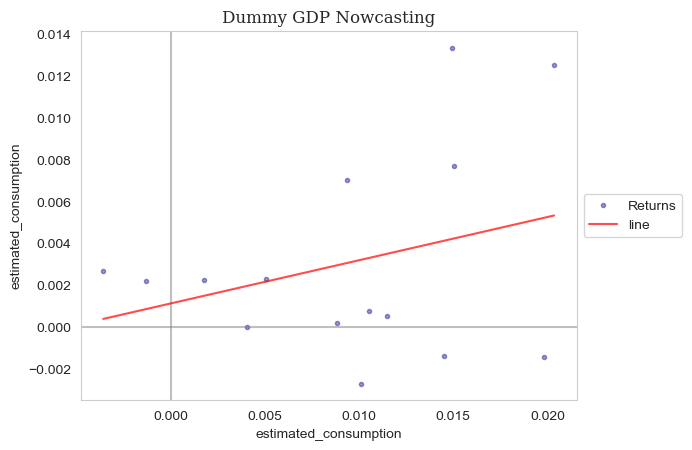

In [85]:
import seaborn as sns
beta, alpha = np.polyfit(x = y_test , y = y_pred ,deg = 1)
plt.axvline(0, color = 'grey', alpha = 0.5)
plt.axhline(0, color = 'grey', alpha = 0.5)
plt.scatter(y = y_pred, x = y_test, label = 'Returns', marker = '.', color = 'navy', alpha = 0.4)
sns.lineplot(x = y_test, y = alpha + y_test * beta, color = 'red', label = 'line', alpha = 0.7)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.title('Dummy GDP Nowcasting', fontfamily = 'Serif')
plt.grid(False)
plt.show()

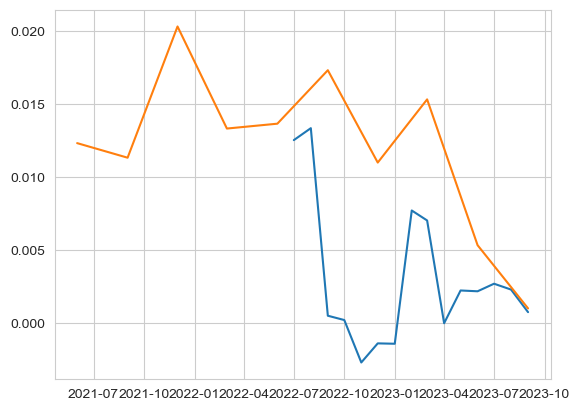

In [86]:
plt.plot(pd.Series(y_pred, index = X_test.index))
plt.plot(gdp_c['consumption_rate'][-10:].dropna() / 3)

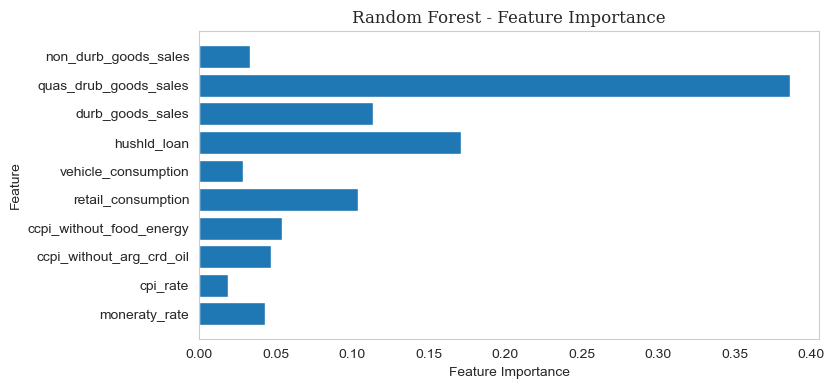

In [87]:
importance = model.feature_importances_
feature_names = X_train.columns

plt.figure(figsize = (8, 4))
plt.barh(range(len(importance)), importance, align="center")
plt.yticks(np.arange(len(importance)), feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.grid(False)
plt.title("Random Forest - Feature Importance", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [93]:
from sklearn.inspection import permutation_importance

importance = permutation_importance(model, X_train, y_train, n_repeats = 30, random_state = 42)
feature_names = X_train.columns

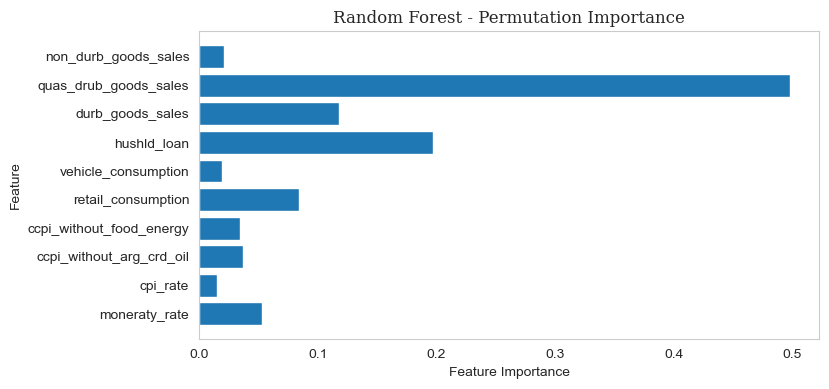

In [97]:
plt.figure(figsize = (8, 4))
plt.barh(range(len(importance['importances_mean'])), importance['importances_mean'], align="center")
plt.yticks(np.arange(len(importance['importances_mean'])), feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.grid(False)
plt.title("Random Forest - Permutation Importance", fontsize = 12, fontfamily = 'Serif')
plt.show()

In [88]:
import shap

X = consumption_matrix.iloc[:,:-1]
y = consumption_matrix['estimated_consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, shuffle = False)

explainer_randomforest_reg = shap.TreeExplainer(model)

shap_values_train = explainer_randomforest_reg(X_train)
shap_values_test = explainer_randomforest_reg(X_test)
shap_values_all = explainer_randomforest_reg(X)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


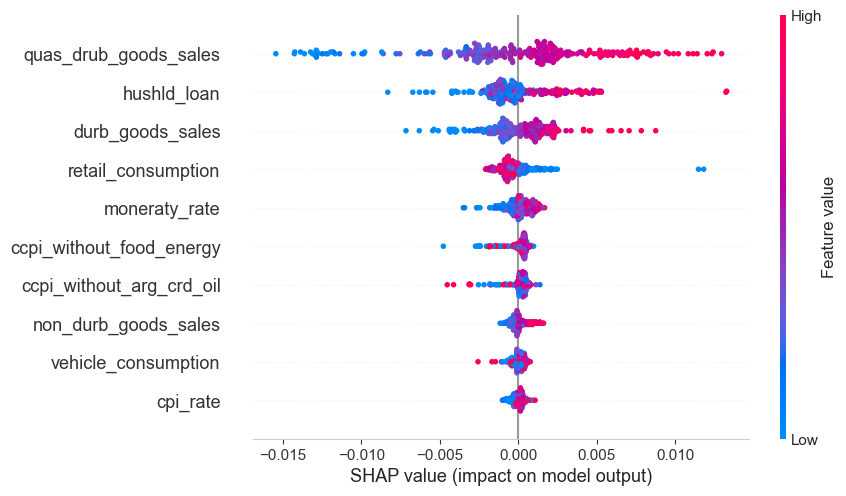

In [89]:
plt.grid(False)
shap.plots.beeswarm(shap_values_train, max_display = len(shap_values_train.feature_names))

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


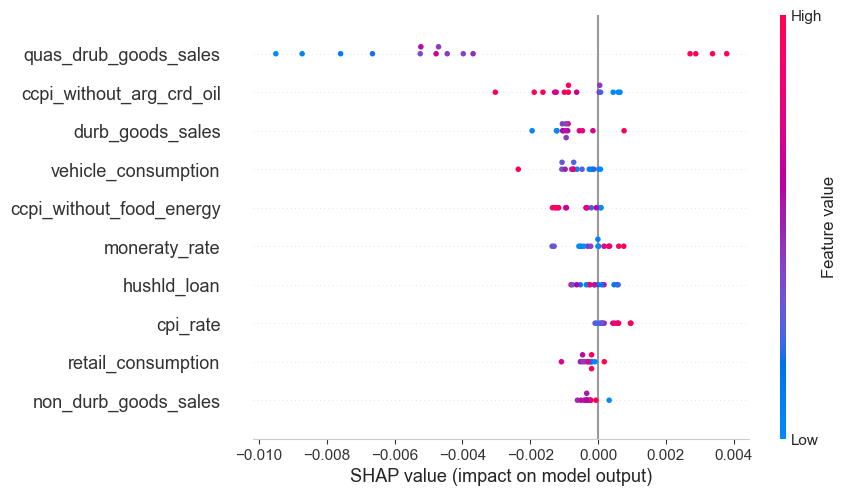

In [74]:
plt.grid(False)
shap.plots.beeswarm(shap_values_test, max_display = len(shap_values_train.feature_names))

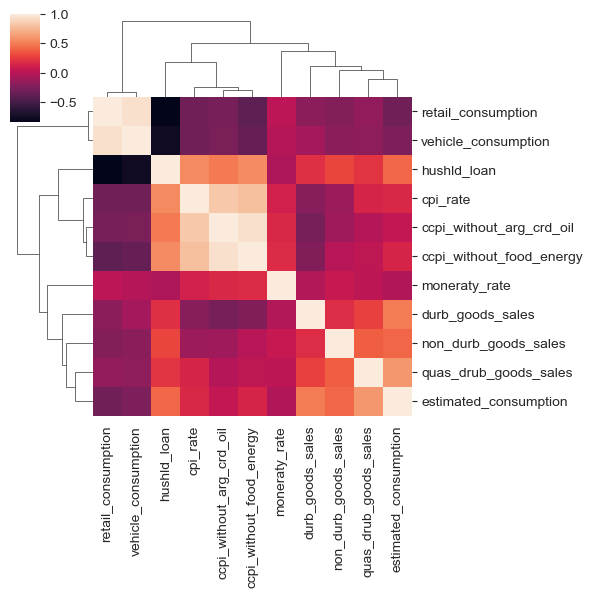

In [91]:
import seaborn as sns

sns.clustermap(consumption_matrix.corr(), figsize = (6,6))